# Model Training & Evaluation

## Objective
In this notebook, we:
- Load the cleaned heart disease dataset
- Split the data into training and test sets
- Train multiple classification models
- Evaluate their performance using standard metrics
- Select and save the best-performing model for deployment

In [14]:
# import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [13]:
# load cleaned data
df = pd.read_csv("../data/processed/cleaned_data.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


In [3]:
# split features & target
X = df.drop("target", axis=1)
y = df["target"]

### Splitting Strategy for Train & Test
- Stratified split is used to preserve class distribution.
- 80% training, 20% testing.

In [15]:
# split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (237, 13)
Test size: (60, 13)


## Model Selection and Pipelines

We evaluate multiple classification models with different characteristics:

- **Logistic Regression**
  - Simple and interpretable
  - Widely used in medical prediction tasks
  - Serves as a strong baseline model

- **Random Forest**
  - Non-linear model capable of capturing complex feature interactions
  - Provides feature importance
  - Robust to noise and outliers

- **Support Vector Machine (SVM)**
  - Effective in high-dimensional spaces
  - Often performs well on small to medium-sized datasets

### Why Pipelines?
- Prevent data leakage by applying preprocessing only on training data
- Ensure consistent preprocessing during cross-validation and deployment
- Improve code modularity and reproducibility

In [5]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True))
    ])
}

## Model Training and Initial Evaluation

Each model is trained on the training dataset and evaluated on the test set.
We compute multiple evaluation metrics to capture different aspects of performance:

- **Accuracy**: Overall correctness
- **Precision**: Reliability of positive predictions
- **Recall**: Ability to detect actual disease cases (critical in healthcare)
- **F1-score**: Balance between precision and recall

In [6]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.833333,0.846154,0.785714,0.814815
1,Random Forest,0.866667,0.884615,0.821429,0.851852
2,SVM,0.850000,0.880000,0.785714,0.830189


## Cross-Validation

To ensure that model performance is not dependent on a single train-test split,
we apply 5-fold cross-validation on the entire dataset.

This provides:
- A more reliable estimate of generalization performance
- Insight into model stability

In [7]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression CV Accuracy: 0.825 ± 0.032
Random Forest CV Accuracy: 0.818 ± 0.048
SVM CV Accuracy: 0.821 ± 0.043


## Model Selection

The final model is selected based on **F1-score**, which is particularly suitable
for medical classification tasks where both false positives and false negatives
carry significant consequences.

The model with the highest F1-score on the test set is chosen for deployment.

In [8]:
best_model_name = results_df.sort_values("F1", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

print("Best model:", best_model_name)

Best model: Random Forest


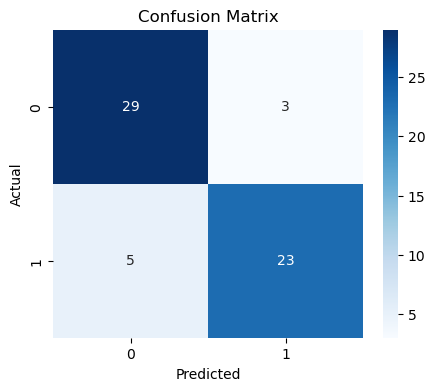

In [16]:
# The confusion matrix provides a detailed breakdown of prediction outcomes, allowing us to analyze false positives and false negatives.
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("../statics/images/confusion_matrix.png", bbox_inches="tight")
plt.show()

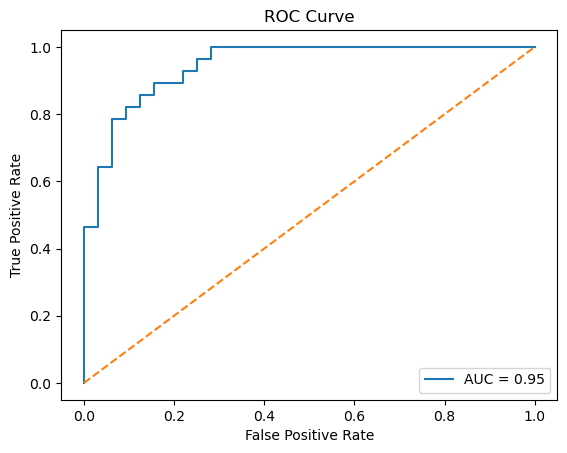

In [17]:
# The ROC curve illustrates the trade-off between true positive rate and false positive rate.
y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("../statics/images/roc_curve.png", bbox_inches="tight")
plt.show()

In [18]:
# save best model for further use
joblib.dump(best_model, "../models/best_model.pkl")
print("Best model saved successfully.")

Best model saved successfully.


## Final Results

- Multiple classification models were trained and evaluated.
- Evaluation metrics included Accuracy, Precision, Recall, F1-score, and ROC-AUC.
- Cross-validation was used to assess model stability.
- The best-performing model was selected based on F1-score.
- The final model was saved for deployment in the Streamlit application.

📌 **Next Step:**  
Build an interactive Streamlit web application for real-time heart disease prediction.